# Interpolate soundings
## vertically from irregularly-spaced pressure levels

with Julia 1.8
author: Simon de Szoeke

In [1]:
using Dates
using NCDatasets
using Interpolations
using Statistics
using PyPlot

In [2]:
# Interpolation methods
# Pressure is irregular and different for each time.

"dv converts Datetimes to numeric values. Needed for Interpolations."
dv(dt, offset=DateTime(2019,3,1)) = Dates.value(dt - offset)

# interpolation functions
function itp_sparse(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"Filter missing data from the input sounding before interpolating."
function itp(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind] .+ x[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end
itp(ds::Dataset, var::String; p=ds["pressure"][:][:]) = itp(ds[var][:][:], p) # convenience method

# example:
# itp(ds, "u_wind")

itp (generic function with 2 methods)

In [3]:
# data from NetCDF
stationname = "trivandrum"
datestamp = Dates.format(DateTime("2019-03-01T00:00"), "yyyymmdd_HHMM") # "20190324_0000"

datapath = joinpath( "../data/igra2", stationname )
joinpath( datapath, "$(stationname)$(datestamp).nc" )

# one sounding per netcdf file
data = NCDatasets.Dataset( joinpath( datapath, "$(stationname)$(datestamp).nc" ) )

# example data - one sounding, one time
u = itp(data, "u_wind")[1000] # works here!
# 

3.1f0

In [4]:
stationname = "trivandrum"
datapath = joinpath( "../data/igra2", stationname )

# define date range
dr = DateTime(2019,3,1):Day(1):DateTime(2019,6,30)
# datestamps = Dates.format.(dr, "yyyymmdd_HHMM")

plevs = 1020.0:-20.0:100.0

# test loading and interpolating u
u = fill( NaN, length(dr), length(plevs) ) # time, pres
for (it, time) in enumerate( DateTime(2019,3,1):Day(1):DateTime(2019,6,30) )
    datestamp = Dates.format(time, "yyyymmdd_HHMM")
    ncfilename = joinpath( datapath, "$(stationname)$(datestamp).nc" )
    if isfile( ncfilename )
        data = NCDatasets.Dataset( ncfilename )
        if sum(isfinite, data["pressure"]) > 1
            u[it, :] = itp(data, "u_wind")[ plevs ]
        end
    else
        # leave u NaNs
    end
end

In [5]:
"Fill workspace variable u with interpolated data from NC sounding files."
function interp_snd_var!( u, varname; plevs=plevs, stationname="trivandrum", daterange=DateTime(2019,3,1):Day(1):DateTime(2019,6,30) )
    fill!( u, NaN ) # guarantee to be filled with nans
    # test loading and interpolating u
    for (it, time) in enumerate( daterange )
        datestamp = Dates.format(time, "yyyymmdd_HHMM")
        datapath = joinpath( "../data/igra2", stationname )
        ncfilename = joinpath( datapath, "$(stationname)$(datestamp).nc" )
        if isfile( ncfilename )
            data = NCDatasets.Dataset( ncfilename )
            if ( sum(isfinite, data[varname][:] .+ data["pressure"][:]) > 1 )
                u[it, :] = itp(data, varname)[ plevs ]
            end
        else
            # leave u NaNs
        end
    end
end

interp_snd_var!

In [6]:
# test sounding data dictionary
arr() = Array{Float64, 2}(undef, length(dr), length(plevs) ) # time, pres
soundings = Dict{String, Array}( "u_wind" => arr() ) 
interp_snd_var!( soundings["u_wind"], "u_wind" )
soundings = Dict{String, Array}( "u_wind" => arr() ) 

# append a variable to the dict
varname = "v_wind"
soundings[varname] = arr()

interp_snd_var!( soundings[varname], varname )

In [7]:
# functions for thermodynamics

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K

# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

"qsat(T[C], p[hPa])"
qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.
# do Tlcl(T, p, ev(p,qv))

Tlcl

In [8]:
"mean along dims, ignoring NaNs"
nanmean(x; dims) = sum(x -> isnan(x) ? 0 : x, x, dims=dims) ./ sum(isfinite, x, dims=dims)
anom(x; dims) = x .- nanmean(x, dims=dims)

anom (generic function with 1 method)

In [11]:
year = 2022

# make sounding data dictionary
varnames = [ "temperature", "dewpoint", "u_wind", "v_wind" ]
dicarr( var ) = ( var, arr() )
soundings = Dict{String, Array}( [dicarr.(varnames)...] )

# fill in with interpolated data from files
for var in varnames
    interp_snd_var!( soundings[var], var; stationname="trivandrum", daterange=DateTime(year,3,1):Day(1):DateTime(year,6,30) )
    # interp_snd_var!( soundings[var], var )
end

# physical variables
Pi = (plevs/1e3).^(-0.287)
th = Pi'.*(273.15.+soundings["temperature"])
thm = nanmean(th, dims=1)

qs = qsat.(soundings["temperature"], plevs')
q = qsat.(soundings["dewpoint"], plevs')
rh = q./qs

# plot winds
mdates = matplotlib.dates

#pcolormesh(dr, plevs, u', vmin=-15, vmax=15, cmap=ColorMap("RdYlBu_r"))
ax1=subplot(2,1,1)
pcolormesh(dr, plevs, soundings["u_wind"]', vmin=-15, vmax=15, cmap=ColorMap("RdYlBu_r"))
ylim([1010, 100])
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
colorbar()
ax2=subplot(2,1,2)
pcolormesh(dr, plevs, soundings["v_wind"]', vmin=-15, vmax=15, cmap=ColorMap("RdYlBu_r"))
ylim([1010, 100])
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
colorbar()

In [26]:
"plot zonal wind and RH for a given year"
function plot_wind_rh_snd( year )

    # get sounding data dictionary
    varnames = [ "temperature", "dewpoint", "u_wind", "v_wind" ]
    dicarr( var ) = ( var, arr() )
    soundings = Dict{String, Array}( [dicarr.(varnames)...] )

    # read interpolated data from files
    for var in varnames
        interp_snd_var!( soundings[var], var; stationname="trivandrum", daterange=DateTime(year,3,1):Day(1):DateTime(year,6,30) )
        # interp_snd_var!( soundings[var], var )
    end
    
    # compute physical variables
    Pi = (plevs/1e3).^(-0.287)
    th = Pi'.*(273.15.+soundings["temperature"])
    thm = nanmean(th, dims=1)

    qs = qsat.(soundings["temperature"], plevs')
    q = qsat.(soundings["dewpoint"], plevs')
    rh = q./qs

    # plot zonal wind
    ax1=subplot(2,1,1)
    pc1 = pcolormesh(dr, plevs, soundings["u_wind"]', vmin=-15, vmax=15, cmap=ColorMap("RdYlBu_r"))
    ylim([1010, 100])
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    colorbar(pc1)
    ax1.set_ylabel("pressure")
    ax1.set_title("zonal wind (m/s)")

    # plot RH
    ax2=subplot(2,1,2)
    # pcolormesh(dr, plevs, 1e3*q', vmin=0, vmax=18, cmap=ColorMap("RdYlBu_r"))
    pc2 = pcolormesh(dr, plevs, rh', vmin=0, vmax=1.0, cmap=ColorMap("RdYlBu_r"))
    contour(dr, plevs, th', colors="k", linewidths=0.25, levels=20)
    ylim([1010, 100])
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_minor_locator(mdates.DayLocator((10, 20)))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    colorbar(pc2)
    ax2.set_ylabel("pressure")
    ax2.set_title("relative humidity")
    
    tight_layout()
    
    return ax1, ax2
end

plot_wind_rh_snd

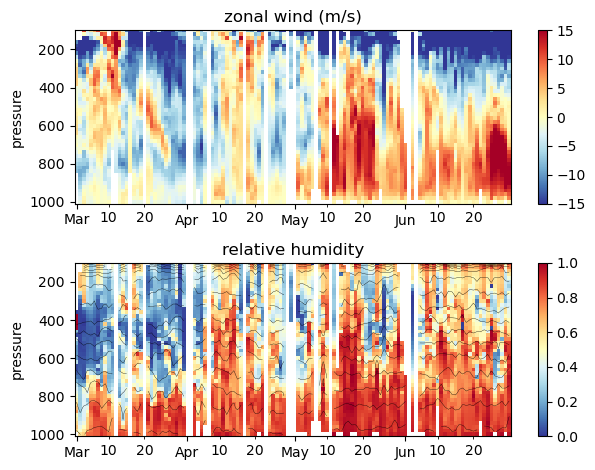

In [27]:
year = 2022
ax1, ax2 = plot_wind_rh_snd( year )
savefig("u_rh_$(year).png")

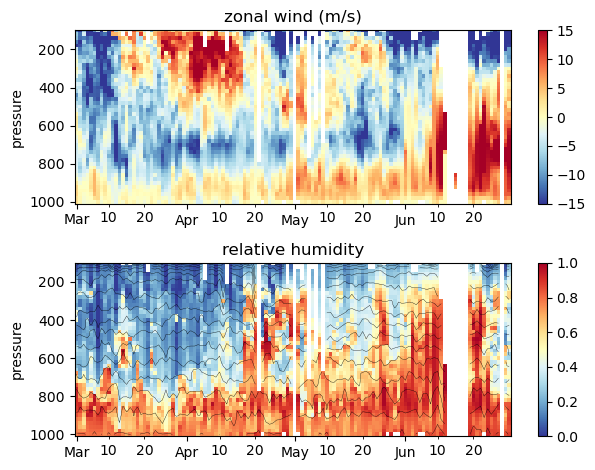

In [28]:
year = 2019
ax1, ax2 = plot_wind_rh_snd( year )
savefig("u_rh_$(year).png")

Trivandrum 2018-2019 humidity precedes wind. Is this an indication of the monsoon onset vortex?

| year | humidity leads zonal wind |
| ---- | ------- |
| 2018 | 20 days |
| 2019 | 10 days |
| 2020 | sounding outages; almost double onset |
| 2021 | major sounding outages |
| 2022 | intraseasonal: RH synchronous with u, active May 10 & June 20. | 


Thiruvananthapuram soundings from 2019 and 2022 provide examples of 2 different types of monsoon onsets. In 2019, there is an onset vortex with deep increased RH 10 days before the onset of westerly winds. In 2022, monsoon intraseasonal oscillations (MISO) have several deep moist RH anomalies around April 10, May 15, and June 15, with near-synchronous pulses of zonal wind April 15 (weak), May 10-20, and June 20-30 modulating the increase of wind over the season.

## 